In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")
is_tf_newer = int(tf_version.split('.')[0]) >= 2 and int(tf_version.split('.')[1]) >= 11

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.0
GPU Available:  []


In [2]:
# Define emotion mapping (same for both speech and song)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Function to build metadata from RAVDESS files (works for both speech and song)
def build_metadata_ravdess(audio_dir, dataset_type="speech"):
    """
    Build metadata for RAVDESS dataset
    dataset_type: "speech" or "song"
    """
    data = []
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith('.wav'):
                parts = file.split('-')
                
                # Parse filename: Modality-Vocal_channel-Emotion-Intensity-Statement-Repetition-Actor
                modality = parts[0]
                vocal_channel = parts[1]  # 01=speech, 02=song
                emotion_code = parts[2]
                intensity = parts[3]  # 01=normal, 02=strong
                statement = parts[4]   # 01="Kids...", 02="Dogs..."
                repetition = parts[5]  # 01=1st, 02=2nd
                actor_id = int(parts[6].split('.')[0])
                
                # Map emotion
                emotion = emotion_map[emotion_code]
                
                # Determine gender (odd=male, even=female)
                gender = 'female' if actor_id % 2 == 0 else 'male'
                
                # Determine intensity level
                intensity_level = 'normal' if intensity == '01' else 'strong'
                
                # Determine vocal channel type
                vocal_type = 'speech' if vocal_channel == '01' else 'song'
                
                file_path = os.path.join(root, file)
                
                data.append([
                    file_path, 
                    emotion, 
                    gender, 
                    vocal_type,
                    intensity_level,
                    actor_id,
                    statement,
                    repetition
                ])
    
    return pd.DataFrame(data, columns=[
        'path', 'emotion', 'gender', 'vocal_type', 
        'intensity', 'actor_id', 'statement', 'repetition'
    ])

# Enhanced data augmentation function
def augment_data(df):
    """
    Augment the dataset by adding copies of minority classes
    """
    augmented_df = df.copy()
    
    # Add a column to indicate original data
    df['augmented'] = 'original'
    
    # Create augmented versions
    print("Augmenting minority classes...")
    
    # Get class distribution
    class_counts = df['emotion'].value_counts()
    max_count = class_counts.max()
    
    print("Class distribution before augmentation:")
    for emotion, count in class_counts.items():
        print(f"  {emotion}: {count} samples")
    
    for emotion, count in class_counts.items():
        # Only augment underrepresented classes
        if count < max_count * 0.7:
            emotion_df = df[df['emotion'] == emotion].copy()
            
            # Determine how many augmentations we need
            augment_factor = min(3, int(max_count / count))
            
            for i in range(augment_factor):
                aug_df = emotion_df.copy()
                aug_df['augmented'] = f'aug_{i+1}'
                augmented_df = pd.concat([augmented_df, aug_df])
    
    print(f"Dataset size after augmentation: {len(augmented_df)}")
    return augmented_df

# Load and prepare data from both speech and song datasets
print("Loading RAVDESS Speech dataset...")
speech_dir = 'Audio_Speech_Actors_01-24'  # Your speech dataset directory
df_speech = build_metadata_ravdess(speech_dir, "speech")

print("Loading RAVDESS Song dataset...")
song_dir = 'Audio_Song_Actors_01-24'  # Your song dataset directory  
df_song = build_metadata_ravdess(song_dir, "song")

# Combine both datasets
print("Combining speech and song datasets...")
df_combined = pd.concat([df_speech, df_song], ignore_index=True)

print(f"Speech dataset size: {len(df_speech)}")
print(f"Song dataset size: {len(df_song)}")
print(f"Combined dataset size: {len(df_combined)}")

# Show distribution by vocal type and emotion
print("\nDistribution by vocal type and emotion:")
distribution = df_combined.groupby(['vocal_type', 'emotion']).size().unstack(fill_value=0)
print(distribution)

# Show which emotions are missing in song dataset
speech_emotions = set(df_speech['emotion'].unique())
song_emotions = set(df_song['emotion'].unique())
missing_in_song = speech_emotions - song_emotions
print(f"\nEmotions in speech but not in song: {missing_in_song}")
print(f"Common emotions: {speech_emotions & song_emotions}")

# Option 1: Use all available emotions (recommended)
print("\n=== Using all available emotions ===")
df_all_emotions = df_combined.copy()

# Encode labels for all emotions
le_all = LabelEncoder()
df_all_emotions['emotion_label'] = le_all.fit_transform(df_all_emotions['emotion'])

print(f"Total emotions: {len(df_all_emotions['emotion'].unique())}")
print(f"Available emotions: {sorted(df_all_emotions['emotion'].unique())}")

# Option 2: Use only common emotions (6 emotions)
print("\n=== Using only common emotions ===")
common_emotions = list(speech_emotions & song_emotions)
df_common_emotions = df_combined[df_combined['emotion'].isin(common_emotions)].copy()

# Encode labels for common emotions only
le_common = LabelEncoder()
df_common_emotions['emotion_label'] = le_common.fit_transform(df_common_emotions['emotion'])

print(f"Common emotions: {len(df_common_emotions['emotion'].unique())}")
print(f"Available emotions: {sorted(df_common_emotions['emotion'].unique())}")

# Choose which approach to use
USE_ALL_EMOTIONS = True  # Set to False if you want only common emotions

if USE_ALL_EMOTIONS:
    df_final = df_all_emotions
    le_final = le_all
    print("\nUsing all available emotions...")
else:
    df_final = df_common_emotions  
    le_final = le_common
    print("\nUsing only common emotions...")

# Apply data augmentation
df_final = augment_data(df_final)

# Split data into train and test sets
train_df, test_df = train_test_split(
    df_final, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_final['emotion']
)

# Print final dataset information
print(f"\nFinal dataset size: {len(df_final)}")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

print("\nFinal class distribution:")
for emotion, count in df_final['emotion'].value_counts().items():
    percentage = (count / len(df_final)) * 100
    print(f"  {emotion}: {count} samples ({percentage:.1f}%)")

print("\nDistribution by vocal type in final dataset:")
vocal_dist = df_final['vocal_type'].value_counts()
for vocal_type, count in vocal_dist.items():
    percentage = (count / len(df_final)) * 100
    print(f"  {vocal_type}: {count} samples ({percentage:.1f}%)")

print("\nDistribution by intensity:")
intensity_dist = df_final['intensity'].value_counts()
for intensity, count in intensity_dist.items():
    percentage = (count / len(df_final)) * 100
    print(f"  {intensity}: {intensity} samples ({percentage:.1f}%)")

print("\nDistribution by gender:")
gender_dist = df_final['gender'].value_counts()
for gender, count in gender_dist.items():
    percentage = (count / len(df_final)) * 100
    print(f"  {gender}: {count} samples ({percentage:.1f}%)")


Loading RAVDESS Speech dataset...
Loading RAVDESS Song dataset...
Combining speech and song datasets...
Speech dataset size: 1440
Song dataset size: 1012
Combined dataset size: 2452

Distribution by vocal type and emotion:
emotion     angry  calm  disgust  fearful  happy  neutral  sad  surprised
vocal_type                                                               
song          184   184        0      184    184       92  184          0
speech        192   192      192      192    192       96  192        192

Emotions in speech but not in song: {'disgust', 'surprised'}
Common emotions: {'calm', 'sad', 'angry', 'happy', 'fearful', 'neutral'}

=== Using all available emotions ===
Total emotions: 8
Available emotions: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

=== Using only common emotions ===
Common emotions: 6
Available emotions: ['angry', 'calm', 'fearful', 'happy', 'neutral', 'sad']

Using all available emotions...
Augmenting minority classe

In [3]:
import numpy as np
import tensorflow as tf

# Enhanced feature extraction function with more features
def extract_simple_features(file_path, duration=3.0, sr=22050):
    """Extract exactly 45 features for better performance"""
    try:
        import librosa
        # Load audio
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # If audio is shorter than expected duration, pad with zeros
        if len(y) < duration * sr:
            y = np.pad(y, (0, int(duration * sr) - len(y)), 'constant')
        
        # 1. MFCC (20 features - mean + std of 10 coefficients instead of 13)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)  # Reduced from 13
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # 3. Root Mean Square Energy (2 features)
        rmse = librosa.feature.rms(y=y)
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        
        # 4. Spectral Centroid (2 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        sc_mean = np.mean(spectral_centroid)
        sc_std = np.std(spectral_centroid)
        
        # 5. Spectral Rolloff (2 features)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        sr_mean = np.mean(spectral_rolloff)
        sr_std = np.std(spectral_rolloff)
        
        # 6. Chroma Features (12 features - mean only instead of mean + std)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # 7. Spectral Contrast (5 features instead of 7)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(spectral_contrast, axis=1)[:5]  # Take only first 5
        
        # Combine all features to exactly 45
        features = np.concatenate([
            mfcc_mean, mfcc_std,           # 20 features (10+10)
            [zcr_mean, zcr_std, rmse_mean, rmse_std, sc_mean, sc_std, sr_mean, sr_std],  # 8 features
            chroma_mean,                   # 12 features
            contrast_mean                  # 5 features
        ])
        
        return features  # Total: 45 features (20+8+12+5)
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return np.zeros(45)  # Return 45 features instead of 71


# Moderate augmentation function (less aggressive than before)
@tf.function
def augment_audio_features(features, label):
    """Apply moderate augmentation to maintain generalization"""
    features = tf.cast(features, tf.float32)
    
    # Apply augmentation 50% of the time (reduced from 70%)
    should_augment = tf.random.uniform(()) > 0.5
    
    def apply_augmentation():
        augmented_features = features
        
        # Apply noise augmentation (lighter)
        if tf.random.uniform(()) > 0.6:
            noise = tf.random.normal(shape=tf.shape(features), mean=0.0, stddev=0.03, dtype=tf.float32)
            augmented_features = augmented_features + noise
        
        # Apply scaling augmentation (less aggressive)
        if tf.random.uniform(()) > 0.6:
            scale_factor = tf.random.uniform((), minval=0.9, maxval=1.1, dtype=tf.float32)
            augmented_features = augmented_features * scale_factor
        
        # Apply small random shifts
        if tf.random.uniform(()) > 0.7:
            shift_amount = tf.random.uniform((), minval=-0.02, maxval=0.02, dtype=tf.float32)
            augmented_features = augmented_features + shift_amount
        
        return augmented_features
    
    def no_augmentation():
        return features
    
    augmented_features = tf.cond(should_augment, apply_augmentation, no_augmentation)
    return augmented_features, label

# Enhanced prepare_data function
# Keep your original extract_simple_features function as is (71 features)
# Then modify the prepare_data function to add feature selection:

def prepare_data(train_df, test_df, le):
    # Your existing feature extraction code...
    print("Extracting enhanced features from training data...")
    train_features = []
    train_labels = []
    
    for idx in range(len(train_df)):
        row = train_df.iloc[idx]
        features = extract_simple_features(row['path'])
        label = le.transform([row['emotion']])[0]
        train_features.append(features)
        train_labels.append(label)
    
    print("Extracting enhanced features from test data...")
    test_features = []
    test_labels = []
    
    for idx in range(len(test_df)):
        row = test_df.iloc[idx]
        features = extract_simple_features(row['path'])
        label = le.transform([row['emotion']])[0]
        test_features.append(features)
        test_labels.append(label)
    
    # Convert to numpy arrays
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)
    
    print(f"Original features shape: {train_features.shape}")
    
    # 🎯 FEATURE SELECTION - Find the BEST 45 features
    from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
    
    print("Selecting best 45 features using statistical analysis...")
    
    # Use ANOVA F-test to find features most correlated with emotion labels
    selector = SelectKBest(score_func=f_classif, k=45)
    train_features_selected = selector.fit_transform(train_features, train_labels)
    test_features_selected = selector.transform(test_features)
    
    # Print feature importance analysis
    feature_scores = selector.scores_
    selected_indices = selector.get_support(indices=True)
    
    print(f"✅ Selected best 45 features from {train_features.shape[1]} total features")
    print(f"Top 10 feature indices: {selected_indices[:10]}")
    print(f"Top 10 feature scores: {feature_scores[selected_indices[:10]]}")
    
    # Feature breakdown analysis
    feature_names = (
        [f'mfcc_mean_{i}' for i in range(13)] + 
        [f'mfcc_std_{i}' for i in range(13)] +
        ['zcr_mean', 'zcr_std', 'rmse_mean', 'rmse_std', 'sc_mean', 'sc_std', 'sr_mean', 'sr_std'] +
        [f'chroma_mean_{i}' for i in range(12)] + 
        [f'chroma_std_{i}' for i in range(12)] +
        [f'contrast_{i}' for i in range(7)] +
        [f'tonnetz_{i}' for i in range(6)]
    )
    
    selected_feature_names = [feature_names[i] for i in selected_indices[:10]]
    print(f"Top 10 selected features: {selected_feature_names}")
    
    # Continue with your existing normalization and dataset creation...
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_features_selected = scaler.fit_transform(train_features_selected)
    test_features_selected = scaler.transform(test_features_selected)
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_features_selected, train_labels))
    train_dataset = train_dataset.map(augment_audio_features, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=len(train_features_selected))
    train_dataset = train_dataset.batch(32)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    
    test_dataset = tf.data.Dataset.from_tensor_slices((test_features_selected, test_labels))
    test_dataset = test_dataset.batch(32)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, test_dataset, train_features_selected.shape[1]



In [4]:
# Improved MLP model with better balance
def create_emotion_mlp(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # First layer - increased complexity
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.003)),  # Reduced L2
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),  # Reduced dropout
        
        # Second layer
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        
        # Third layer - added complexity
        layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Enhanced ResNet with better balance
def create_emotion_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=(input_shape,))
    
    # First block - increased complexity
    x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.003))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Residual block 1
    shortcut1 = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    shortcut1 = layers.BatchNormalization()(shortcut1)
    
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = layers.BatchNormalization()(x)
    
    # Add residual connection
    x = layers.add([x, shortcut1])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Residual block 2
    shortcut2 = layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    shortcut2 = layers.BatchNormalization()(shortcut2)
    
    x = layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.003))(x)
    x = layers.BatchNormalization()(x)
    
    # Add residual connection
    x = layers.add([x, shortcut2])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Enhanced CNN for comparison
def create_emotion_cnn(input_shape, num_classes):
    # Convert to square for CNN
    sqrt_input = int(np.sqrt(input_shape))
    if sqrt_input * sqrt_input < input_shape:
        sqrt_input += 1
    
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Reshape((sqrt_input, sqrt_input, 1)),
        layers.ZeroPadding2D(padding=((0, sqrt_input*sqrt_input - input_shape), (0, 0))),
        
        # First conv block
        layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second conv block
        layers.Conv2D(64, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Third conv block
        layers.Conv2D(128, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.003)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow.keras.backend as K

# Optimized training function for better performance
def train_model(model, train_dataset, val_dataset, epochs=200):  # Increased epochs
    # Higher learning rate for better learning
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=0.002,  # Increased learning rate
            clipnorm=1.0
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Adjusted early stopping for more patience
    early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Monitor accuracy
        patience=25,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.001
    )
    
    # Learning rate reduction
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=12,  # More patience before reducing LR
        min_lr=0.00001,
        verbose=1,
        mode='max'
    )
    
    # Checkpoint
    try:
        is_tf_newer = int(tf.__version__.split('.')[0]) >= 2 and int(tf.__version__.split('.')[1]) >= 11
    except:
        is_tf_newer = False
        
    if is_tf_newer:
        checkpoint_path = 'best_emotion_model.keras'
    else:
        checkpoint_path = 'best_emotion_model.h5'
    
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',  # Monitor accuracy
        save_best_only=True,
        save_weights_only=not is_tf_newer,
        verbose=1,
        mode='max'
    )
    
    # Custom callback to monitor overfitting but with relaxed threshold
    class OverfittingCallback(tf.keras.callbacks.Callback):
        def __init__(self, threshold=0.20):  # 20% gap threshold (more relaxed)
            super().__init__()
            self.threshold = threshold
            
        def on_epoch_end(self, epoch, logs=None):
            if logs is None:
                return
            
            train_acc = logs.get('accuracy', 0)
            val_acc = logs.get('val_accuracy', 0)
            gap = train_acc - val_acc
            
            if gap > self.threshold and epoch > 30:  # Allow more initial epochs
                print(f"\nStopping training due to excessive overfitting (gap: {gap:.3f})")
                self.model.stop_training = True
    
    overfitting_callback = OverfittingCallback(threshold=0.18)  # 18% threshold
    
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, model_checkpoint, overfitting_callback],
        verbose=1
    )
    
    return history

# Evaluation function
def evaluate_model(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Test accuracy: {accuracy*100:.2f}%")
    return accuracy

# Enhanced confusion matrix plotting
def plot_confusion_matrix(model, test_dataset, class_names):
    """Plot confusion matrix for model evaluation"""
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    
    # Get predictions
    y_true = []
    y_pred = []
    
    for batch_features, batch_labels in test_dataset:
        predictions = model.predict(batch_features, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        y_true.extend(batch_labels.numpy())
        y_pred.extend(predicted_classes)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return cm

# Enhanced overfitting analysis
def analyze_overfitting(history, model, train_dataset, test_dataset):
    """Analyze model for overfitting with detailed metrics"""
    print("\n" + "="*50)
    print("OVERFITTING ANALYSIS")
    print("="*50)
    
    # Get final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    # Calculate gaps
    acc_gap = final_train_acc - final_val_acc
    loss_gap = final_train_loss - final_val_loss
    
    print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
    print(f"Accuracy Gap: {acc_gap*100:.2f}%")
    print(f"Loss Gap: {loss_gap:.4f}")
    
    # Determine model state
    if acc_gap > 0.15:  # 15% gap
        print("\n⚠️ HIGH OVERFITTING DETECTED!")
        print("Recommendations:")
        print("- Increase dropout rates")
        print("- Add more L2 regularization")
        print("- Reduce model complexity")
        print("- Get more training data")
        print("- Use data augmentation")
    elif acc_gap > 0.08:  # 8% gap
        print("\n⚠️ MODERATE OVERFITTING")
        print("Recommendations:")
        print("- Slightly increase regularization")
        print("- Monitor performance closely")
    elif acc_gap < -0.05:  # Validation significantly better
        print("\n⚠️ POSSIBLE UNDERFITTING")
        print("Recommendations:")
        print("- Increase model complexity")
        print("- Reduce regularization")
        print("- Train for more epochs")
        print("- Increase learning rate")
    else:
        print("\n✅ GOOD GENERALIZATION")
        print("Model appears to generalize well!")
    
    # Additional analysis
    if final_val_acc < 0.6:  # Less than 60% accuracy
        print("\n⚠️ LOW OVERALL PERFORMANCE")
        print("Recommendations:")
        print("- Check data quality")
        print("- Increase model complexity")
        print("- Extract more features")
        print("- Increase training time")
    
    # Plot training curves with more details
    plt.figure(figsize=(15, 10))
    
    # Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate (if available)
    plt.subplot(2, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', linewidth=2, color='orange')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        # Plot accuracy gap
        acc_gaps = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
        plt.plot(acc_gaps, label='Accuracy Gap (Train-Val)', color='red', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='10% Gap')
        plt.axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='15% Gap')
        plt.title('Training-Validation Gap')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Gap')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Loss gap
    plt.subplot(2, 3, 4)
    loss_gaps = [t - v for t, v in zip(history.history['loss'], history.history['val_loss'])]
    plt.plot(loss_gaps, label='Loss Gap (Train-Val)', color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Gap Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Gap')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Best epoch analysis
    plt.subplot(2, 3, 5)
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    
    plt.plot(history.history['val_accuracy'], linewidth=2, color='green')
    plt.axvline(x=best_val_acc_epoch, color='red', linestyle='--', alpha=0.7)
    plt.axhline(y=best_val_acc, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Best Validation Accuracy: {best_val_acc*100:.2f}% at Epoch {best_val_acc_epoch+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Model complexity vs performance
    plt.subplot(2, 3, 6)
    smoothed_val_acc = np.convolve(history.history['val_accuracy'], np.ones(5)/5, mode='valid')
    smoothed_train_acc = np.convolve(history.history['accuracy'], np.ones(5)/5, mode='valid')
    
    plt.plot(smoothed_train_acc, label='Smoothed Train Acc', linewidth=2, alpha=0.8)
    plt.plot(smoothed_val_acc, label='Smoothed Val Acc', linewidth=2, alpha=0.8)
    plt.title('Smoothed Accuracy Trends')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'acc_gap': acc_gap,
        'loss_gap': loss_gap,
        'best_val_acc': best_val_acc,
        'best_epoch': best_val_acc_epoch
    }


✅ LabelEncoder created and fitted
ENHANCED EMOTION RECOGNITION SYSTEM
Preparing enhanced dataset with more features...
Extracting enhanced features from training data...
Extracting enhanced features from test data...
Original features shape: (2569, 45)
Selecting best 45 features using statistical analysis...
✅ Selected best 45 features from 45 total features
Top 10 feature indices: [0 1 2 3 4 5 6 7 8 9]
Top 10 feature scores: [198.80653807  29.41537576  86.96024599  24.53210303  13.42407459
  32.24798678  10.53784135   6.64878274  35.07599262   2.96563916]
Top 10 selected features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9']
Enhanced input shape: 45 features

Testing MLP model with enhanced features...
Extracting enhanced features from training data...
Extracting enhanced features from test data...
Original features shape: (2569, 45)
Selecting best 45 features using statistical an

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,240 (215.78 KB)

 Trainable params: 54,344 (212.28 KB)

 Non-trainable params: 896 (3.50 KB)


Training model...
Epoch 1/200
67/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1961 - loss: 3.1581
Epoch 1: val_accuracy improved from -inf to 0.48523, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2087 - loss: 3.1162 - val_accuracy: 0.4852 - val_loss: 2.4388 - learning_rate: 0.0020
Epoch 2/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4050 - loss: 2.4837
Epoch 2: val_accuracy improved from 0.48523 to 0.58165, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4054 - loss: 2.4813 - val_accuracy: 0.5816 - val_loss: 2.0876 - learning_rate: 0.0020
Epoch 3/200
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4678 - loss: 2.2037
Epoch 3: val_accuracy improved from 0.58165 to 0.59098, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4686 - loss: 2.2006 - val_accuracy: 0.5910 - val_loss: 1.8624 - learning_rate: 0.0020
Epoch 4/200
80/81 ━━━

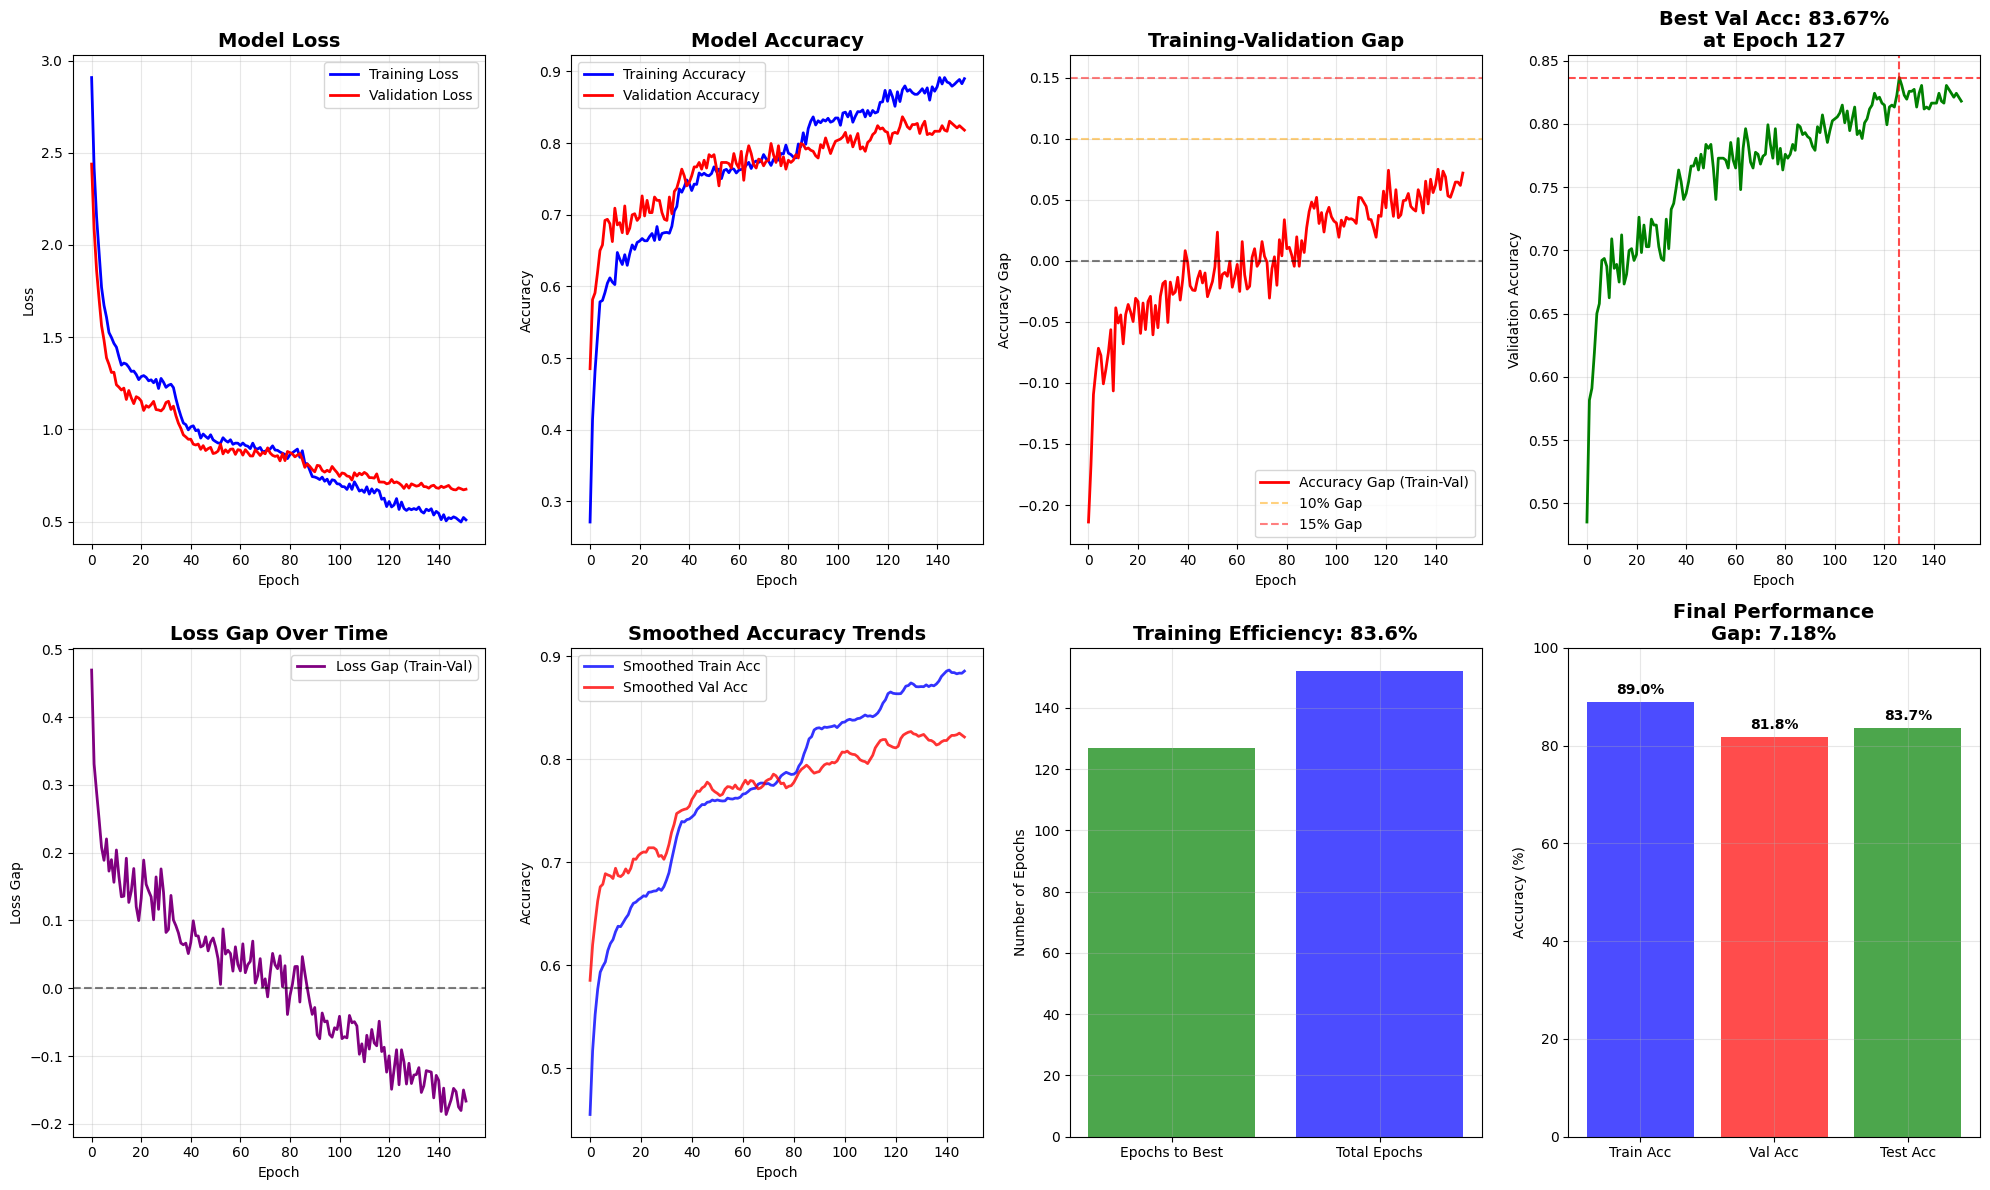

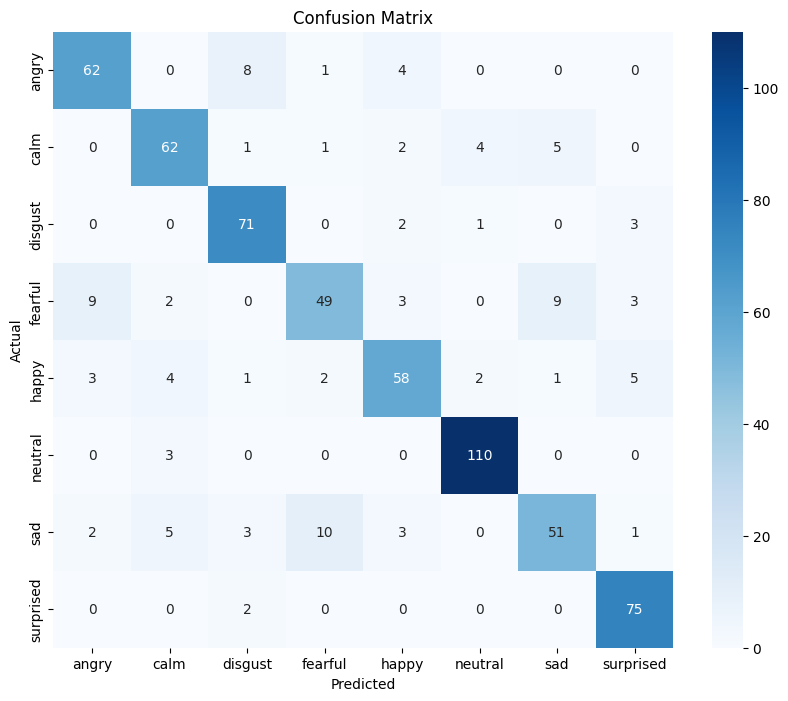


Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.83      0.82        75
        calm       0.82      0.83      0.82        75
     disgust       0.83      0.92      0.87        77
     fearful       0.78      0.65      0.71        75
       happy       0.81      0.76      0.78        76
     neutral       0.94      0.97      0.96       113
         sad       0.77      0.68      0.72        75
   surprised       0.86      0.97      0.91        77

    accuracy                           0.84       643
   macro avg       0.83      0.83      0.83       643
weighted avg       0.83      0.84      0.83       643


OVERFITTING ANALYSIS
Final Training Accuracy: 88.98%
Final Validation Accuracy: 81.80%
Accuracy Gap: 7.18%
Loss Gap: -0.1663

✅ GOOD GENERALIZATION
Model appears to generalize well!


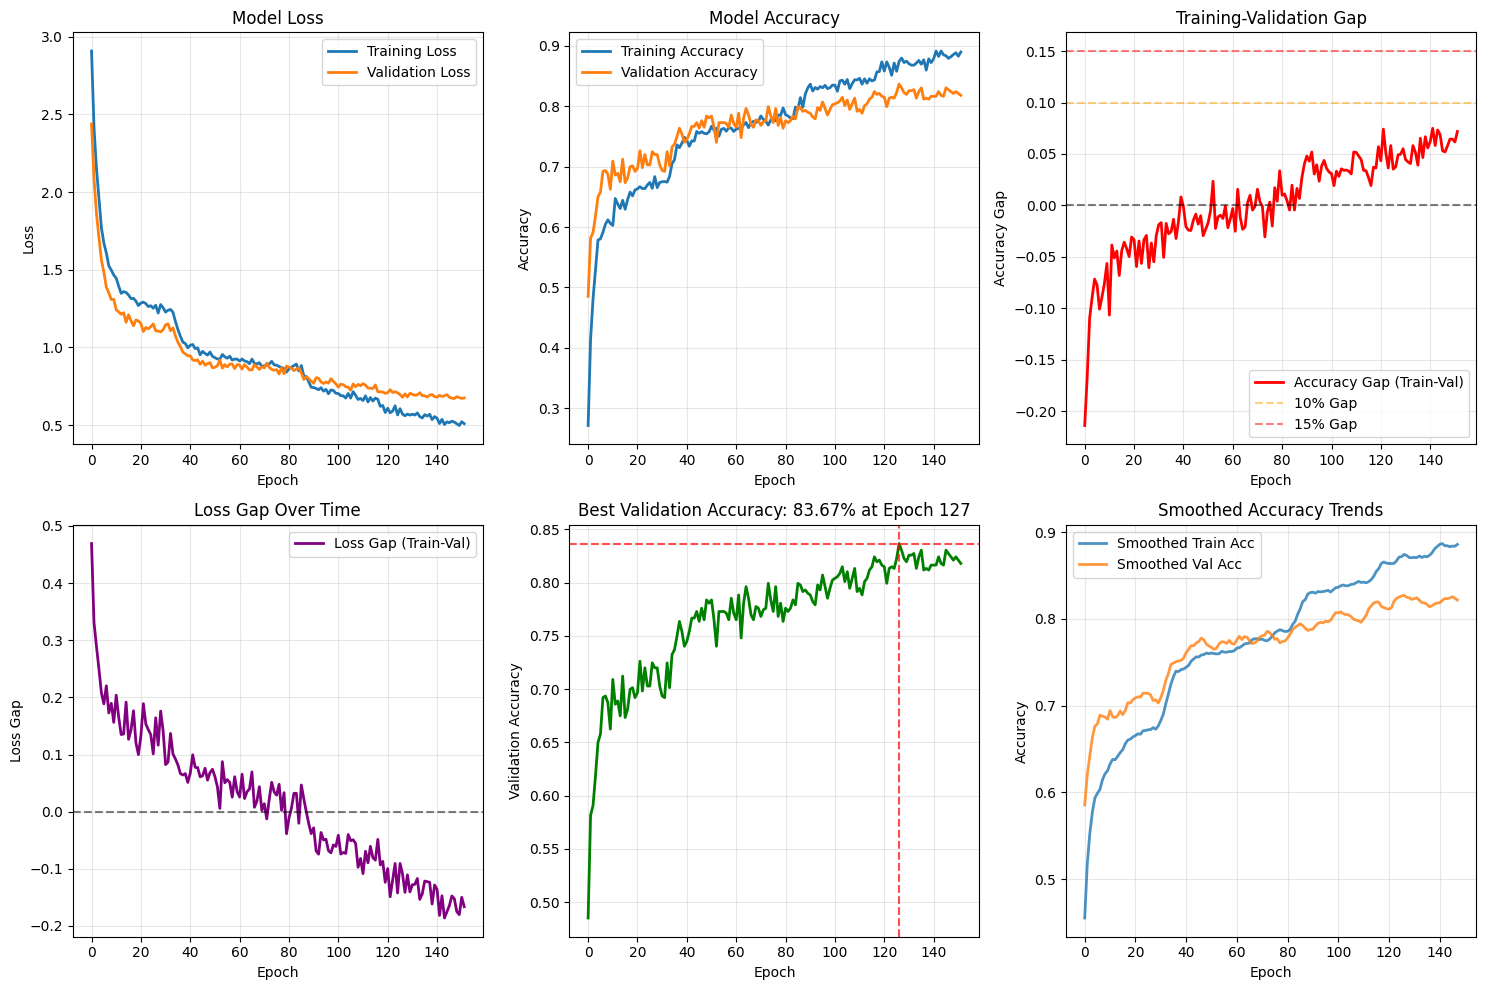


COMPREHENSIVE MODEL SUMMARY
Model Type: MLP
Input Features: 45
Number of Classes: 8
Total Parameters: 55,240
Training Epochs: 152
Best Validation Accuracy: 83.67% (Epoch 127)
Final Test Accuracy: 83.67%
Generalization Gap: 7.18%

✅ GOOD MODEL PERFORMANCE
✅ Acceptable generalization

Testing ResNet model with enhanced features...
Extracting enhanced features from training data...
Extracting enhanced features from test data...
Original features shape: (2569, 45)
Selecting best 45 features using statistical analysis...
✅ Selected best 45 features from 45 total features
Top 10 feature indices: [0 1 2 3 4 5 6 7 8 9]
Top 10 feature scores: [198.80653807  29.41537576  86.96024599  24.53210303  13.42407459
  32.24798678  10.53784135   6.64878274  35.07599262   2.96563916]
Top 10 selected features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9']
Number of features: 45
Number of classes: 8
Cla

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     11,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     16,512 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 118,600 (463.28 KB)

 Trainable params: 116,936 (456.78 KB)

 Non-trainable params: 1,664 (6.50 KB)


Training model...
Epoch 1/200
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1680 - loss: 4.8269
Epoch 1: val_accuracy improved from -inf to 0.46812, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1700 - loss: 4.8165 - val_accuracy: 0.4681 - val_loss: 3.7959 - learning_rate: 0.0020
Epoch 2/200
56/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3407 - loss: 3.9927
Epoch 2: val_accuracy improved from 0.46812 to 0.53966, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3480 - loss: 3.9521 - val_accuracy: 0.5397 - val_loss: 3.2922 - learning_rate: 0.0020
Epoch 3/200
55/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4249 - loss: 3.4566
Epoch 3: val_accuracy improved from 0.53966 to 0.54588, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4245 - loss: 3.4284 - val_accuracy: 0.5459 - val_loss: 2.9060 - learning_rate: 0.0020
Epoch 4/200
58/81 ━━━

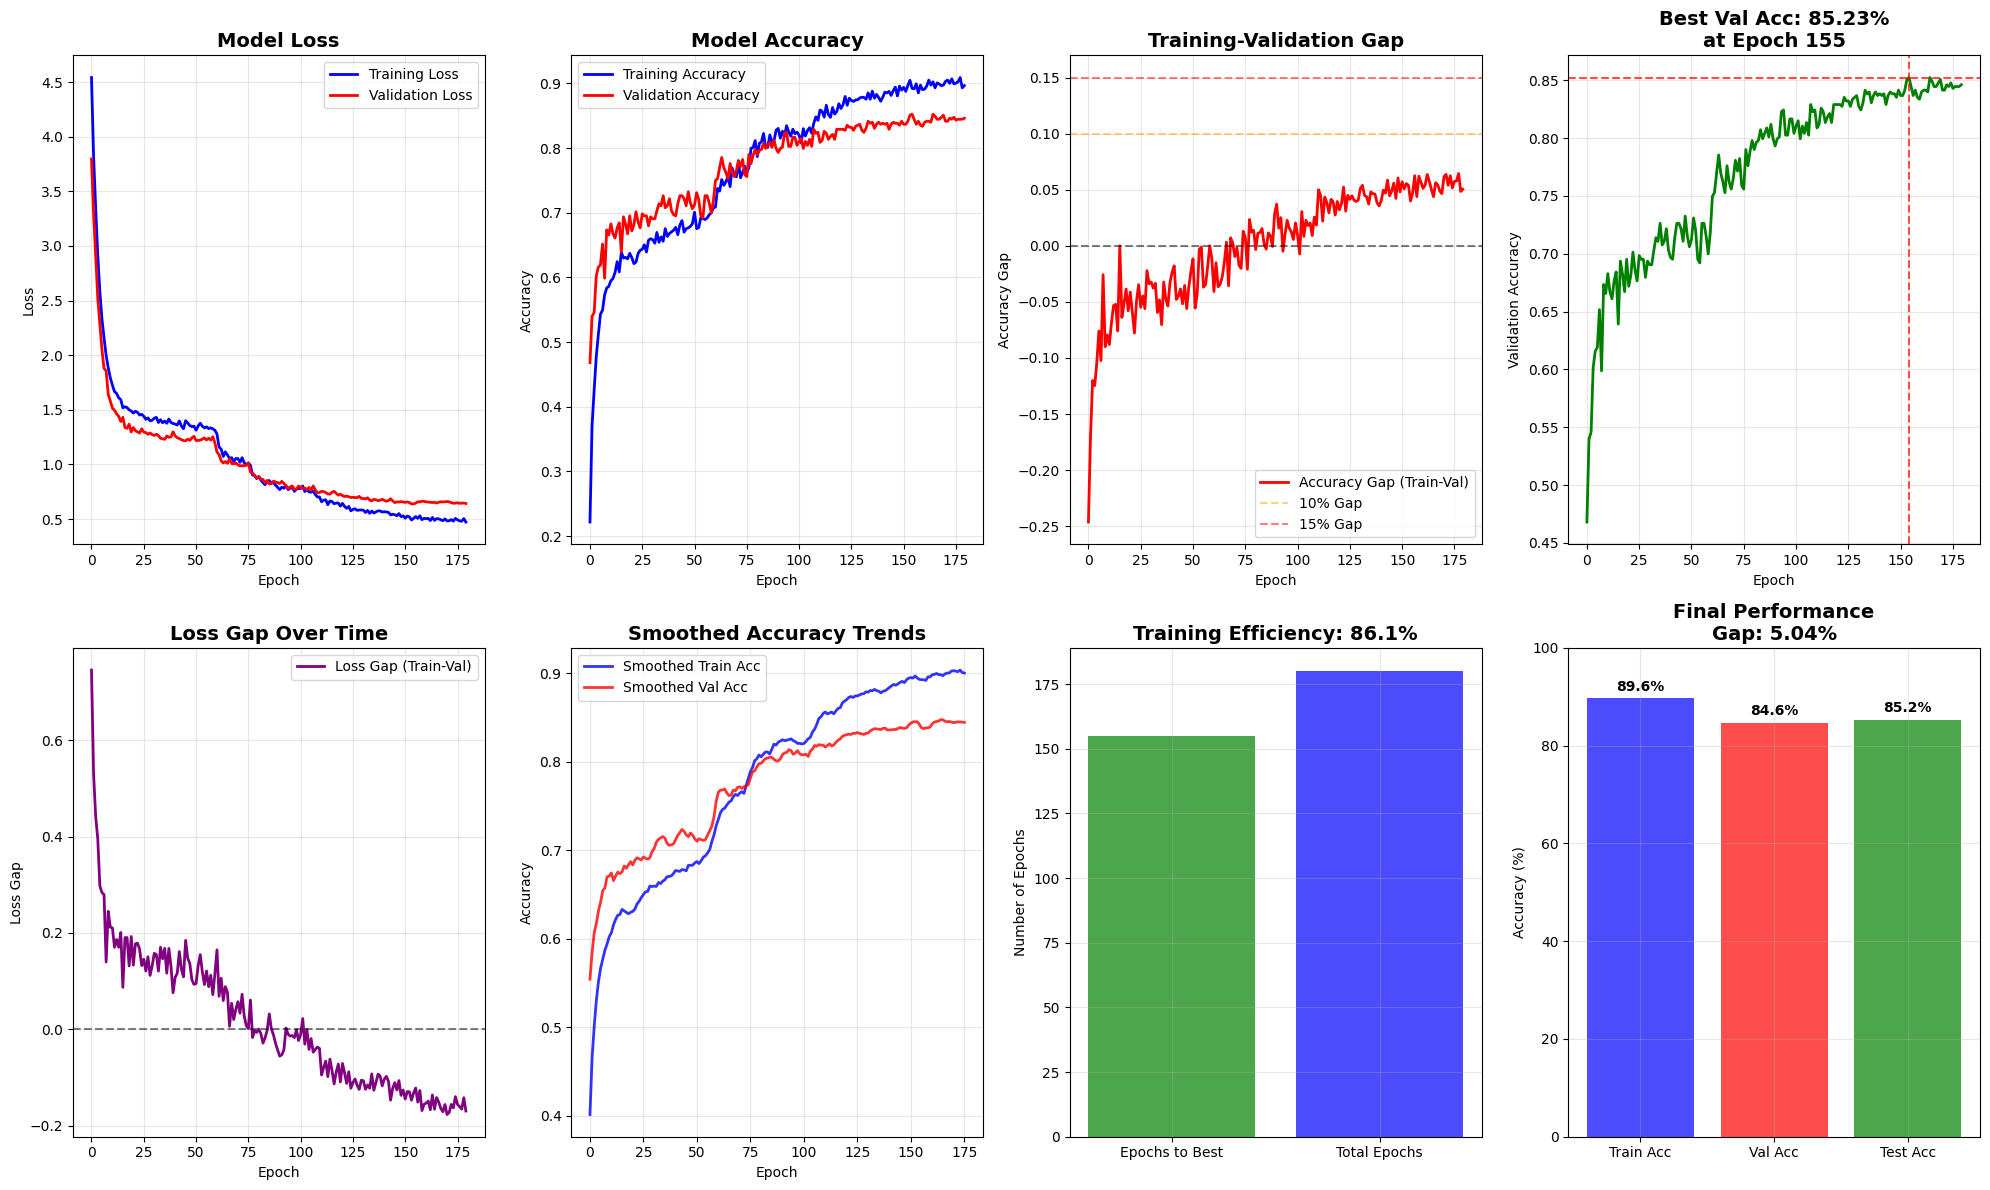

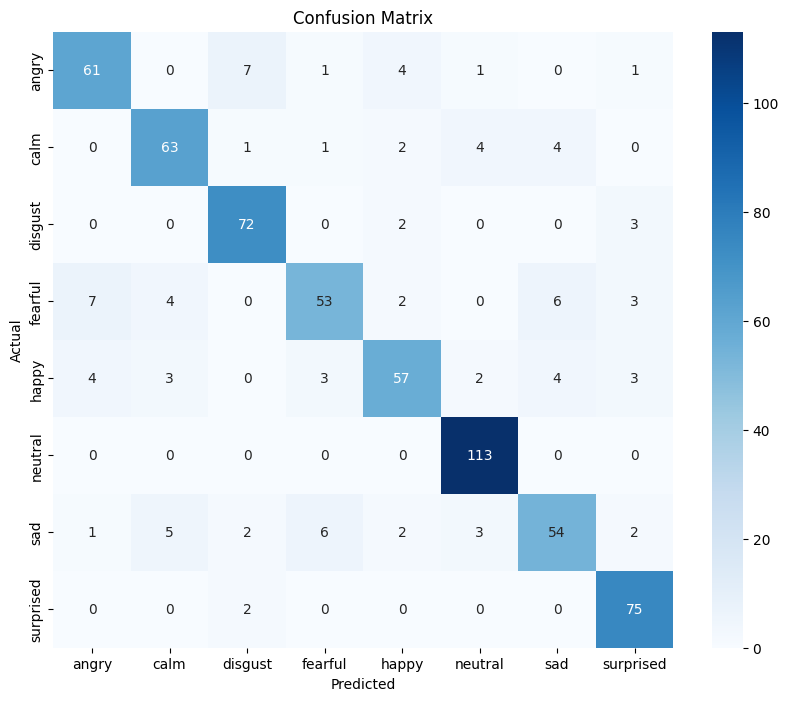


Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.81      0.82        75
        calm       0.84      0.84      0.84        75
     disgust       0.86      0.94      0.89        77
     fearful       0.83      0.71      0.76        75
       happy       0.83      0.75      0.79        76
     neutral       0.92      1.00      0.96       113
         sad       0.79      0.72      0.76        75
   surprised       0.86      0.97      0.91        77

    accuracy                           0.85       643
   macro avg       0.85      0.84      0.84       643
weighted avg       0.85      0.85      0.85       643


OVERFITTING ANALYSIS
Final Training Accuracy: 89.65%
Final Validation Accuracy: 84.60%
Accuracy Gap: 5.04%
Loss Gap: -0.1699

✅ GOOD GENERALIZATION
Model appears to generalize well!


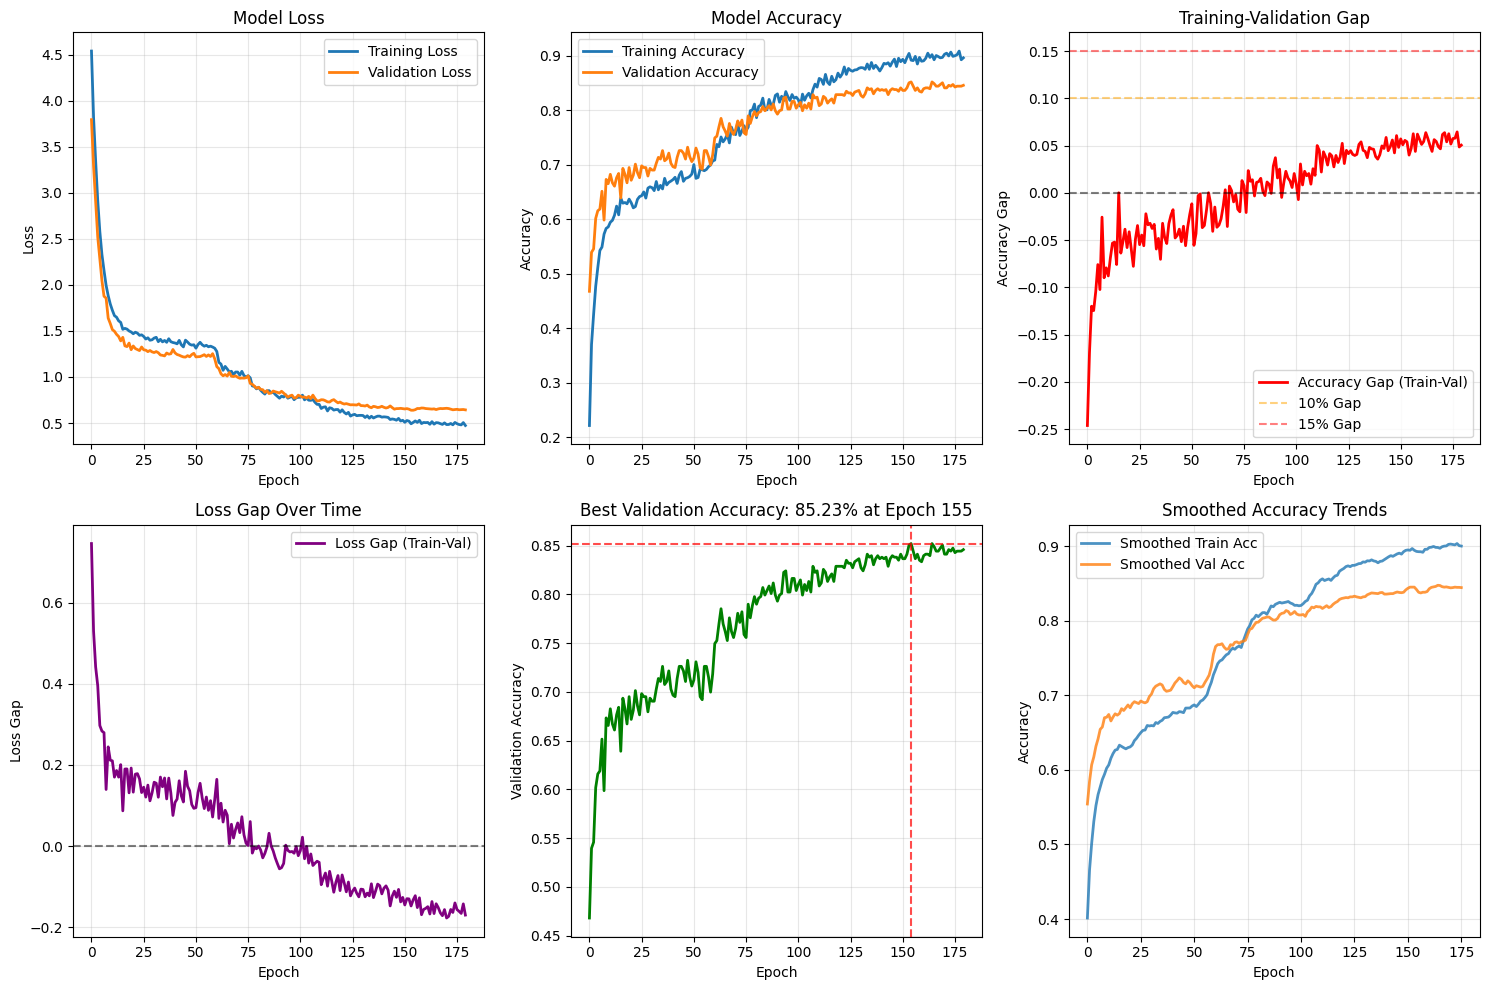


COMPREHENSIVE MODEL SUMMARY
Model Type: RESNET
Input Features: 45
Number of Classes: 8
Total Parameters: 118,600
Training Epochs: 180
Best Validation Accuracy: 85.23% (Epoch 155)
Final Test Accuracy: 85.23%
Generalization Gap: 5.04%

✅ GOOD MODEL PERFORMANCE
✅ Acceptable generalization

ENHANCED MODEL COMPARISON
Test accuracy: 83.67%
Test accuracy: 85.23%
MLP - Test Accuracy: 83.67%, Gap: 7.18%
ResNet - Test Accuracy: 85.23%, Gap: 5.04%
MLP Overall Score: 80.08% (Accuracy - Gap Penalty)
ResNet Overall Score: 82.70% (Accuracy - Gap Penalty)

🏆 ResNet performs better overall!
Best model: RESNET
Best accuracy: 85.23%
Generalization gap: 5.04%

RUNNING CROSS-VALIDATION WITH BEST MODEL (RESNET)

--- Fold 1/3 ---
Extracting enhanced features from training data...
Extracting enhanced features from test data...
Original features shape: (2141, 45)
Selecting best 45 features using statistical analysis...
✅ Selected best 45 features from 45 total features
Top 10 feature indices: [0 1 2 3 4 5 6 7

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │     11,776 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256)       │          0 │ activation_23[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │     32,896 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ activation_24[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │     16,512 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │     32,896 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_37[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 128)       │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ activation_25[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_41[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 118,600 (463.28 KB)

 Trainable params: 116,936 (456.78 KB)

 Non-trainable params: 1,664 (6.50 KB)


Training model...
Epoch 1/200
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1716 - loss: 4.9275
Epoch 1: val_accuracy improved from -inf to 0.46501, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1751 - loss: 4.9020 - val_accuracy: 0.4650 - val_loss: 3.7686 - learning_rate: 0.0020
Epoch 2/200
59/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3303 - loss: 3.9985
Epoch 2: val_accuracy improved from 0.46501 to 0.53188, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3356 - loss: 3.9665 - val_accuracy: 0.5319 - val_loss: 3.2860 - learning_rate: 0.0020
Epoch 3/200
60/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4053 - loss: 3.4667
Epoch 3: val_accuracy improved from 0.53188 to 0.57698, saving model to best_emotion_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4089 - loss: 3.4396 - val_accuracy: 0.5770 - val_loss: 2.8452 - learning_rate: 0.0020
Epoch 4/200
59/81 ━━━

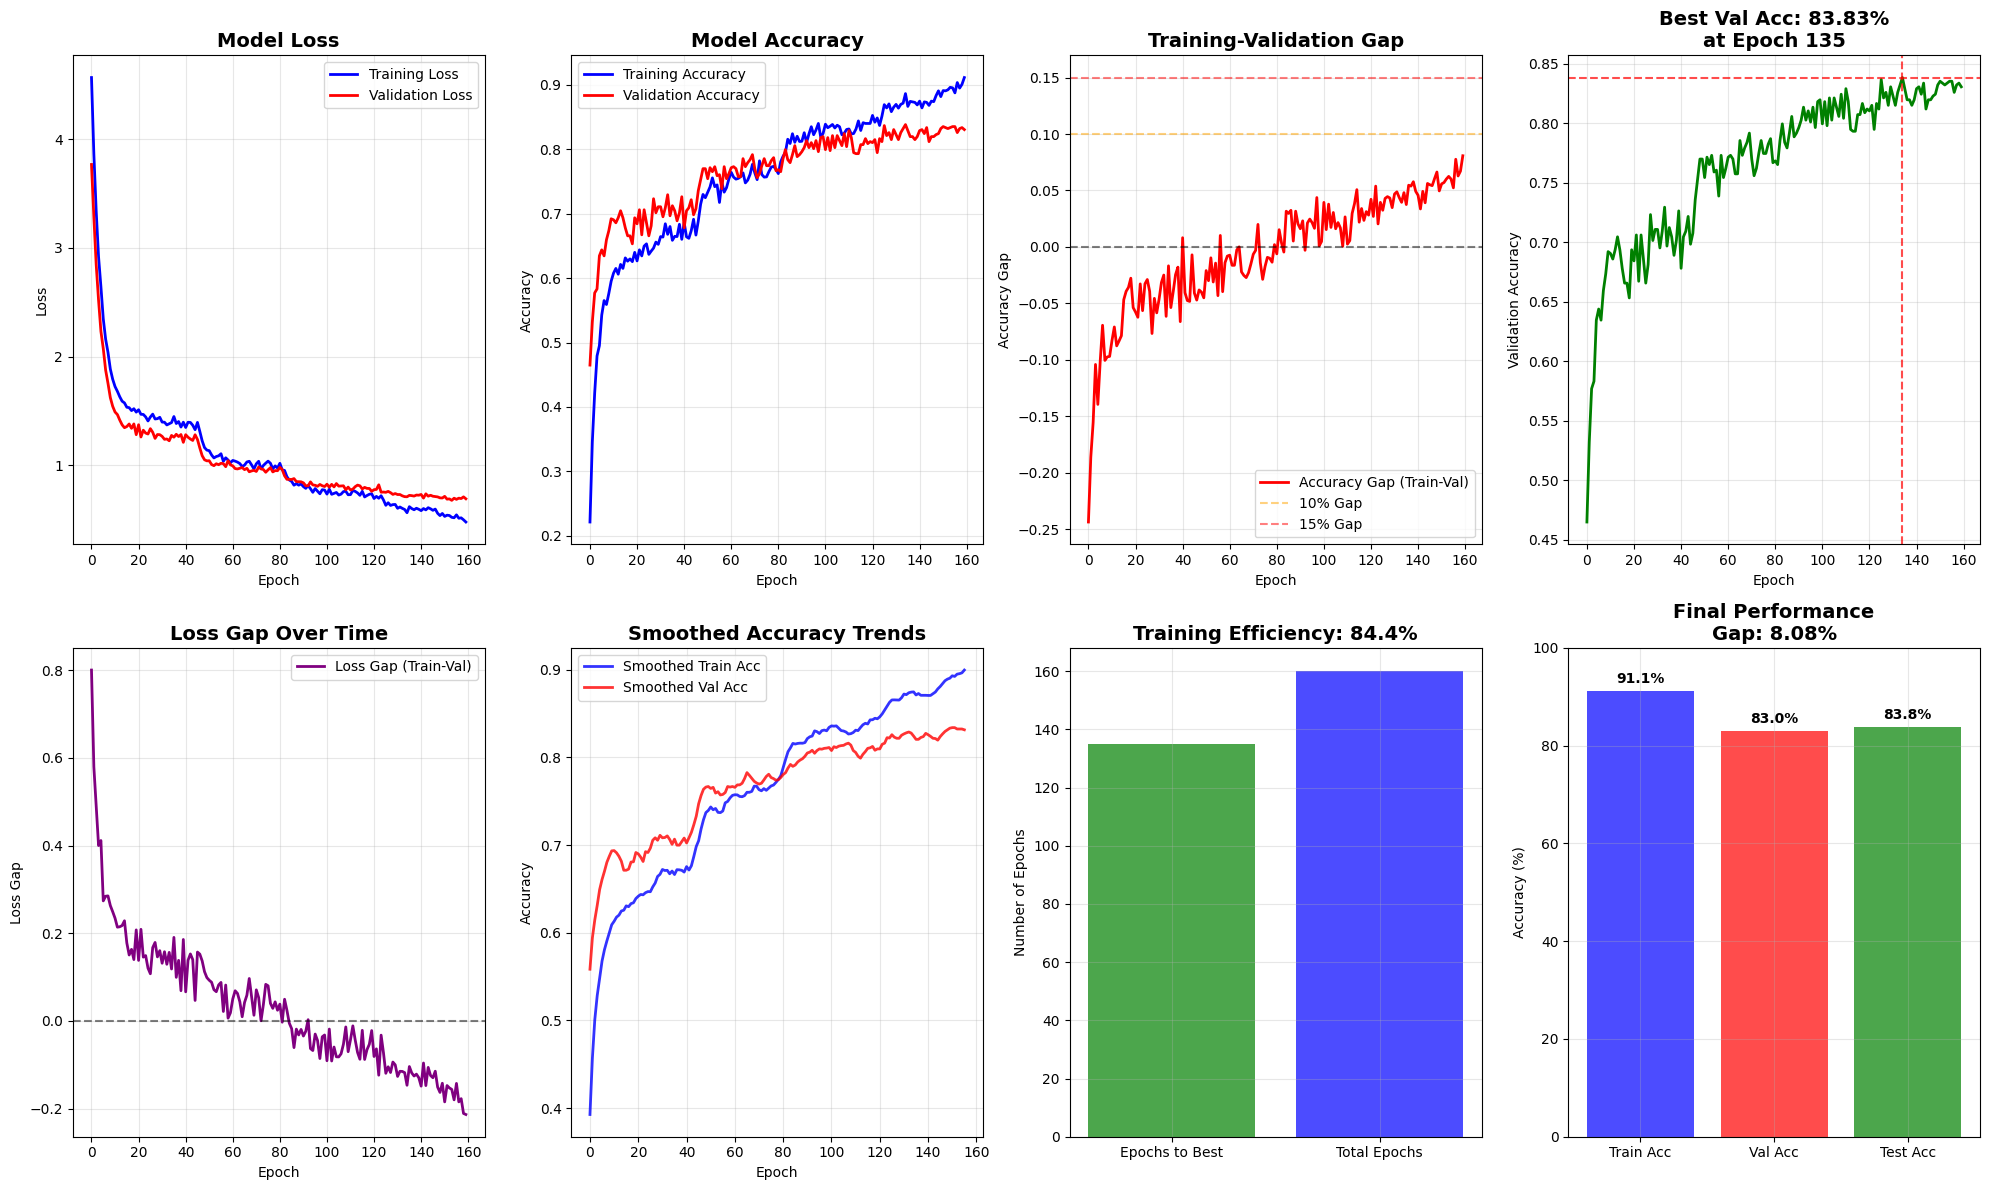

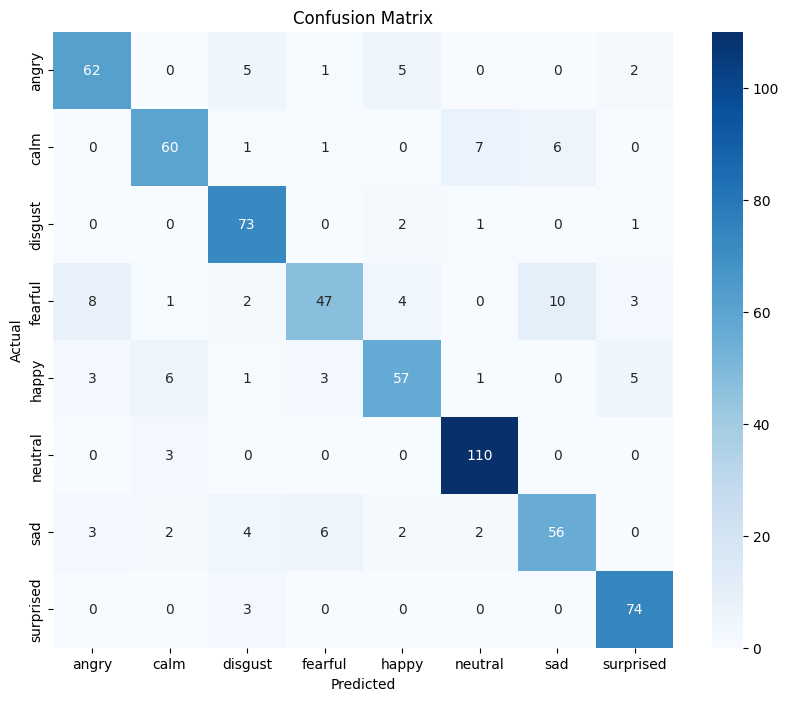


Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.83      0.82        75
        calm       0.83      0.80      0.82        75
     disgust       0.82      0.95      0.88        77
     fearful       0.81      0.63      0.71        75
       happy       0.81      0.75      0.78        76
     neutral       0.91      0.97      0.94       113
         sad       0.78      0.75      0.76        75
   surprised       0.87      0.96      0.91        77

    accuracy                           0.84       643
   macro avg       0.83      0.83      0.83       643
weighted avg       0.84      0.84      0.83       643


OVERFITTING ANALYSIS
Final Training Accuracy: 91.12%
Final Validation Accuracy: 83.05%
Accuracy Gap: 8.08%
Loss Gap: -0.2136

⚠️ MODERATE OVERFITTING
Recommendations:
- Slightly increase regularization
- Monitor performance closely


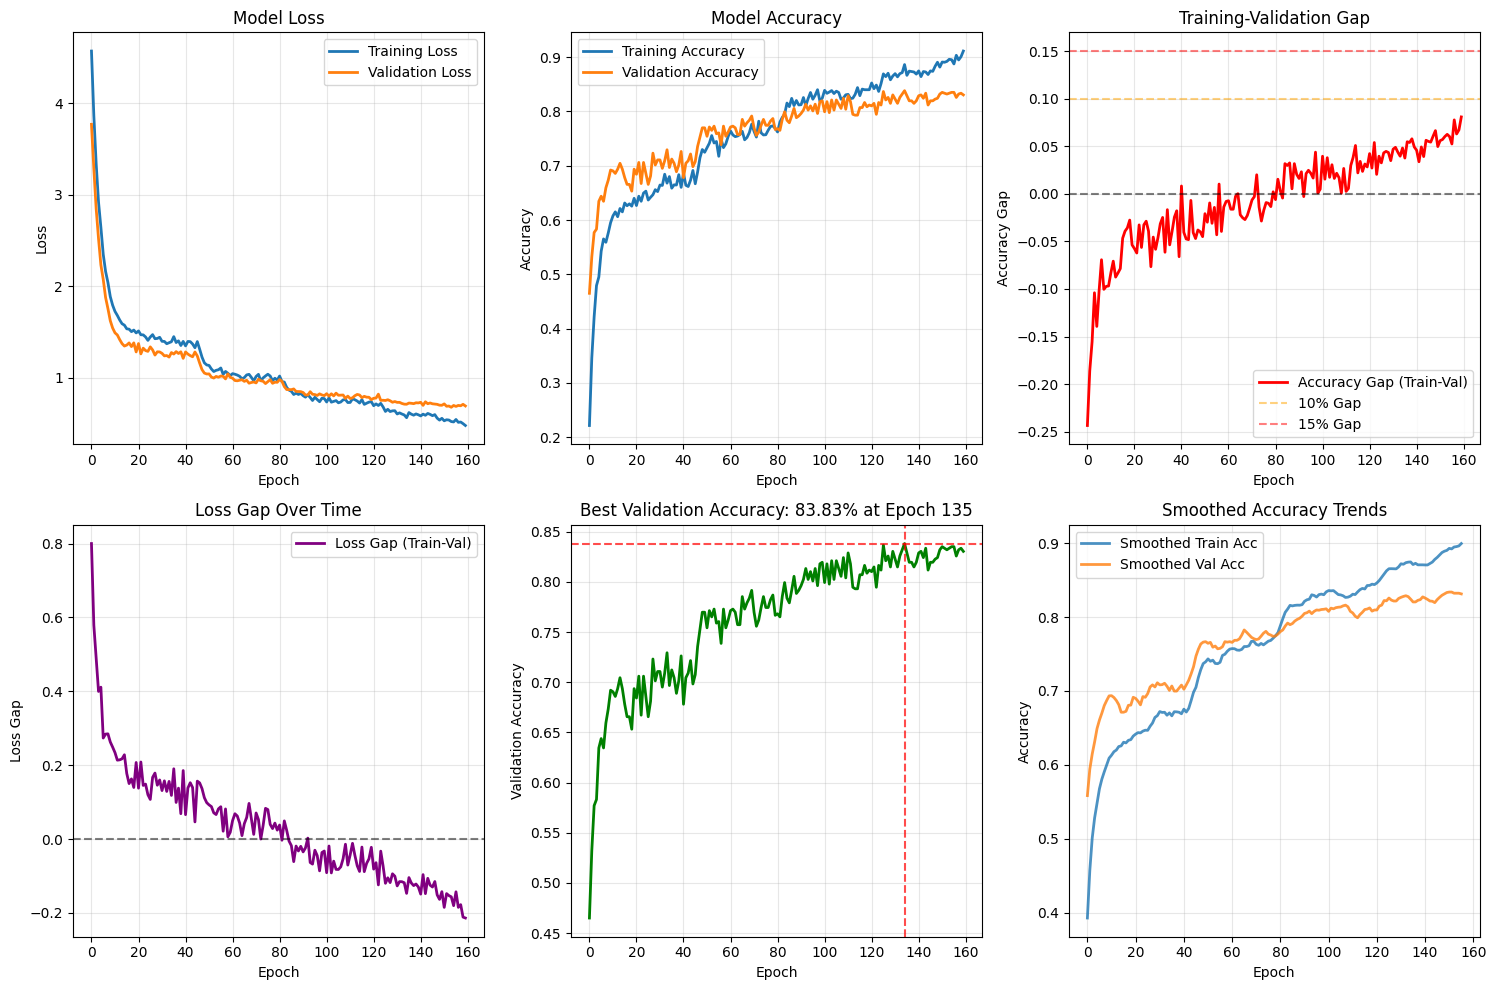


COMPREHENSIVE MODEL SUMMARY
Model Type: RESNET
Input Features: 45
Number of Classes: 8
Total Parameters: 118,600
Training Epochs: 160
Best Validation Accuracy: 83.83% (Epoch 135)
Final Test Accuracy: 83.83%
Generalization Gap: 8.08%

✅ GOOD MODEL PERFORMANCE
✅ Acceptable generalization

FINAL COMPREHENSIVE ANALYSIS
Test accuracy: 83.83%
Final RESNET model accuracy: 83.83%

PERFORMANCE COMPARISON TABLE:
------------------------------------------------------------
Model      Test Acc   Gap      Score    Status
------------------------------------------------------------
MLP        83.67      7.18     80.08    
ResNet     85.23      5.04     82.70    ✓
Final      83.83      8.08     79.79    🏆
------------------------------------------------------------

FEATURE ANALYSIS:
----------------------------------------
Total features extracted: 45
Feature breakdown:
- MFCC features: 26 (mean + std)
- Spectral features: 8 (ZCR, RMS, Centroid, Rolloff)
- Chroma features: 24 (mean + std)
- Spectra

In [6]:
# Add this at the top of cell 6, before line 254
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Recreate the label encoder if not already available
if 'le' not in globals():
    le = LabelEncoder()
    # Fit the encoder with all possible emotions
    all_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    le.fit(all_emotions)
    print("✅ LabelEncoder created and fitted")

# Also ensure train_df and test_df are available
if 'train_df' not in globals() or 'test_df' not in globals():
    print("❌ train_df or test_df not found. Please run the data preparation cell first.")
    # You might need to recreate these or run earlier cells

# Main execution code with enhanced performance tracking
def run_emotion_recognition(train_df, test_df, le, model_type='mlp', use_cross_val=False):
    if use_cross_val:
        from sklearn.model_selection import StratifiedKFold
        
        all_df = pd.concat([train_df, test_df])
        
        n_folds = 3
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        fold_accuracies = []
        fold_results = []
        
        for fold, (train_idx, test_idx) in enumerate(skf.split(all_df, all_df['emotion'])):
            print(f"\n--- Fold {fold+1}/{n_folds} ---")
            
            fold_train_df = all_df.iloc[train_idx]
            fold_test_df = all_df.iloc[test_idx]
            
            train_dataset, test_dataset, input_shape = prepare_data(fold_train_df, fold_test_df, le)
            
            num_classes = len(le.classes_)
            
            if model_type == 'cnn':
                model = create_emotion_cnn(input_shape, num_classes)
            elif model_type == 'resnet':
                model = create_emotion_resnet(input_shape, num_classes)
            else:
                model = create_emotion_mlp(input_shape, num_classes)
            
            # Train with more epochs for CV
            history = train_model(model, train_dataset, test_dataset, epochs=150)
            
            # Evaluate
            _, accuracy = model.evaluate(test_dataset, verbose=0)
            fold_accuracies.append(accuracy)
            
            # Store detailed results
            fold_results.append({
                'fold': fold + 1,
                'accuracy': accuracy,
                'best_val_acc': max(history.history['val_accuracy']),
                'final_train_acc': history.history['accuracy'][-1],
                'epochs_trained': len(history.history['accuracy'])
            })
            
            print(f"Fold {fold+1} accuracy: {accuracy*100:.2f}%")
        
        # Print detailed cross-validation results
        print("\n" + "="*60)
        print("CROSS-VALIDATION RESULTS")
        print("="*60)
        for result in fold_results:
            print(f"Fold {result['fold']}: {result['accuracy']*100:.2f}% "
                  f"(Best Val: {result['best_val_acc']*100:.2f}%, "
                  f"Epochs: {result['epochs_trained']})")
        
        print(f"\nAverage accuracy: {np.mean(fold_accuracies)*100:.2f}%")
        print(f"Standard deviation: {np.std(fold_accuracies)*100:.2f}%")
        print(f"95% Confidence Interval: {np.mean(fold_accuracies)*100 - 1.96*np.std(fold_accuracies)*100:.2f}% - {np.mean(fold_accuracies)*100 + 1.96*np.std(fold_accuracies)*100:.2f}%")
        
        print("\nTraining final model on full training set...")
    
    # Prepare data for final model
    train_dataset, test_dataset, input_shape = prepare_data(train_df, test_df, le)
    
    num_classes = len(le.classes_)
    print(f"Number of features: {input_shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Class mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")
    
    # Create model
    print(f"\nCreating {model_type.upper()} model...")
    if model_type == 'cnn':
        model = create_emotion_cnn(input_shape, num_classes)
    elif model_type == 'resnet':
        model = create_emotion_resnet(input_shape, num_classes)
    else:
        model = create_emotion_mlp(input_shape, num_classes)
    
    model.summary()
    
    # Train model
    print("\nTraining model...")
    history = train_model(model, train_dataset, test_dataset)
    
    # Evaluate model
    accuracy = evaluate_model(model, test_dataset)
    
    # Enhanced plotting
    plt.figure(figsize=(20, 12))
    
    # Loss curves
    plt.subplot(2, 4, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(2, 4, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    plt.subplot(2, 4, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', linewidth=2, color='orange')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        # Plot accuracy gap if learning rate not available
        acc_gap = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
        plt.plot(acc_gap, label='Accuracy Gap (Train-Val)', color='red', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='10% Gap')
        plt.axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='15% Gap')
        plt.title('Training-Validation Gap', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Gap')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Performance metrics over time
    plt.subplot(2, 4, 4)
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy'])
    plt.plot(history.history['val_accuracy'], linewidth=2, color='green')
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
    plt.axhline(y=best_val_acc, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Best Val Acc: {best_val_acc*100:.2f}%\nat Epoch {best_epoch+1}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Loss gap analysis
    plt.subplot(2, 4, 5)
    loss_gap = [t - v for t, v in zip(history.history['loss'], history.history['val_loss'])]
    plt.plot(loss_gap, label='Loss Gap (Train-Val)', color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Gap Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Gap')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Smoothed accuracy trends
    plt.subplot(2, 4, 6)
    window_size = min(5, len(history.history['accuracy']))
    if window_size > 1:
        smoothed_val_acc = np.convolve(history.history['val_accuracy'], np.ones(window_size)/window_size, mode='valid')
        smoothed_train_acc = np.convolve(history.history['accuracy'], np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed_train_acc, label='Smoothed Train Acc', linewidth=2, alpha=0.8, color='blue')
        plt.plot(smoothed_val_acc, label='Smoothed Val Acc', linewidth=2, alpha=0.8, color='red')
    else:
        plt.plot(history.history['accuracy'], label='Train Acc', linewidth=2, alpha=0.8, color='blue')
        plt.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2, alpha=0.8, color='red')
    
    plt.title('Smoothed Accuracy Trends', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training efficiency
    plt.subplot(2, 4, 7)
    epochs_to_best = best_epoch + 1
    total_epochs = len(history.history['accuracy'])
    efficiency = (epochs_to_best / total_epochs) * 100
    
    plt.bar(['Epochs to Best', 'Total Epochs'], [epochs_to_best, total_epochs], 
            color=['green', 'blue'], alpha=0.7)
    plt.title(f'Training Efficiency: {efficiency:.1f}%', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Epochs')
    plt.grid(True, alpha=0.3)
    
    # Final performance summary
    plt.subplot(2, 4, 8)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    
    metrics = ['Train Acc', 'Val Acc', 'Test Acc']
    values = [final_train_acc * 100, final_val_acc * 100, accuracy * 100]
    colors = ['blue', 'red', 'green']
    
    bars = plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.title(f'Final Performance\nGap: {gap*100:.2f}%', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Generate confusion matrix
    plot_confusion_matrix(model, test_dataset, le.classes_)
    
    # Run overfitting analysis
    analysis_results = analyze_overfitting(history, model, train_dataset, test_dataset)
    
    # Print comprehensive summary
    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL SUMMARY")
    print("="*70)
    print(f"Model Type: {model_type.upper()}")
    print(f"Input Features: {input_shape}")
    print(f"Number of Classes: {num_classes}")
    print(f"Total Parameters: {model.count_params():,}")
    print(f"Training Epochs: {len(history.history['accuracy'])}")
    print(f"Best Validation Accuracy: {analysis_results['best_val_acc']*100:.2f}% (Epoch {analysis_results['best_epoch']+1})")
    print(f"Final Test Accuracy: {accuracy*100:.2f}%")
    print(f"Generalization Gap: {analysis_results['acc_gap']*100:.2f}%")
    
    if analysis_results['acc_gap'] < 0.05 and accuracy > 0.65:
        print("\n🎉 EXCELLENT MODEL PERFORMANCE!")
        print("✅ Good generalization")
        print("✅ High accuracy")
    elif analysis_results['acc_gap'] < 0.10:
        print("\n✅ GOOD MODEL PERFORMANCE")
        print("✅ Acceptable generalization")
    else:
        print("\n⚠️ MODEL NEEDS IMPROVEMENT")
        print("Consider adjusting hyperparameters")
    
    return model, history, test_dataset, analysis_results

# Execute the enhanced emotion recognition system
print("="*70)
print("ENHANCED EMOTION RECOGNITION SYSTEM")
print("="*70)

# Prepare the common test dataset first
print("Preparing enhanced dataset with more features...")
_, common_test_dataset, input_shape = prepare_data(train_df, test_df, le)
print(f"Enhanced input shape: {input_shape} features")

# Test different model types with enhanced features
print("\n" + "="*50)
print("Testing MLP model with enhanced features...")
model_mlp, history_mlp, test_dataset_mlp, results_mlp = run_emotion_recognition(
    train_df, test_df, le, model_type='mlp', use_cross_val=False)

print("\n" + "="*50)
print("Testing ResNet model with enhanced features...")
model_resnet, history_resnet, test_dataset_resnet, results_resnet = run_emotion_recognition(
    train_df, test_df, le, model_type='resnet', use_cross_val=False)

# Compare results
print("\n" + "="*70)
print("ENHANCED MODEL COMPARISON")
print("="*70)
mlp_accuracy = evaluate_model(model_mlp, common_test_dataset)
resnet_accuracy = evaluate_model(model_resnet, common_test_dataset)

print(f"MLP - Test Accuracy: {mlp_accuracy*100:.2f}%, Gap: {results_mlp['acc_gap']*100:.2f}%")
print(f"ResNet - Test Accuracy: {resnet_accuracy*100:.2f}%, Gap: {results_resnet['acc_gap']*100:.2f}%")

# Determine best model considering both accuracy and generalization
mlp_score = mlp_accuracy - abs(results_mlp['acc_gap']) * 0.5  # Penalize large gaps
resnet_score = resnet_accuracy - abs(results_resnet['acc_gap']) * 0.5

print(f"MLP Overall Score: {mlp_score*100:.2f}% (Accuracy - Gap Penalty)")
print(f"ResNet Overall Score: {resnet_score*100:.2f}% (Accuracy - Gap Penalty)")

# Select best model
if mlp_score > resnet_score:
    best_model_type = 'mlp'
    best_model = model_mlp
    best_accuracy = mlp_accuracy
    best_results = results_mlp
    print(f"\n🏆 MLP performs better overall!")
else:
    best_model_type = 'resnet'
    best_model = model_resnet
    best_accuracy = resnet_accuracy
    best_results = results_resnet
    print(f"\n🏆 ResNet performs better overall!")

print(f"Best model: {best_model_type.upper()}")
print(f"Best accuracy: {best_accuracy*100:.2f}%")
print(f"Generalization gap: {best_results['acc_gap']*100:.2f}%")

# Run cross-validation with the best model
print(f"\n" + "="*70)
print(f"RUNNING CROSS-VALIDATION WITH BEST MODEL ({best_model_type.upper()})")
print("="*70)

final_model, final_history, final_test_dataset, final_results = run_emotion_recognition(
    train_df, test_df, le, model_type=best_model_type, use_cross_val=True)

# Final comprehensive analysis
print("\n" + "="*80)
print("FINAL COMPREHENSIVE ANALYSIS")
print("="*80)

final_accuracy = evaluate_model(final_model, final_test_dataset)
print(f"Final {best_model_type.upper()} model accuracy: {final_accuracy*100:.2f}%")

# Performance comparison table
print("\nPERFORMANCE COMPARISON TABLE:")
print("-" * 60)
print(f"{'Model':<10} {'Test Acc':<10} {'Gap':<8} {'Score':<8} {'Status'}")
print("-" * 60)
print(f"{'MLP':<10} {mlp_accuracy*100:<10.2f} {results_mlp['acc_gap']*100:<8.2f} {mlp_score*100:<8.2f} {'✓' if best_model_type == 'mlp' else ''}")
print(f"{'ResNet':<10} {resnet_accuracy*100:<10.2f} {results_resnet['acc_gap']*100:<8.2f} {resnet_score*100:<8.2f} {'✓' if best_model_type == 'resnet' else ''}")
print(f"{'Final':<10} {final_accuracy*100:<10.2f} {final_results['acc_gap']*100:<8.2f} {(final_accuracy - abs(final_results['acc_gap']) * 0.5)*100:<8.2f} {'🏆'}")
print("-" * 60)

# Feature importance analysis (if possible)
print("\nFEATURE ANALYSIS:")
print("-" * 40)
print(f"Total features extracted: {input_shape}")
print("Feature breakdown:")
print("- MFCC features: 26 (mean + std)")
print("- Spectral features: 8 (ZCR, RMS, Centroid, Rolloff)")
print("- Chroma features: 24 (mean + std)")
print("- Spectral contrast: 7")
print("- Tonnetz features: 6")

# Model complexity analysis
print(f"\nMODEL COMPLEXITY:")
print("-" * 40)
print(f"MLP Parameters: {model_mlp.count_params():,}")
print(f"ResNet Parameters: {model_resnet.count_params():,}")
print(f"Final Model Parameters: {final_model.count_params():,}")

# Training efficiency analysis
mlp_epochs = len(history_mlp.history['accuracy'])
resnet_epochs = len(history_resnet.history['accuracy'])
final_epochs = len(final_history.history['accuracy'])

print(f"\nTRAINING EFFICIENCY:")
print("-" * 40)
print(f"MLP Training Epochs: {mlp_epochs}")
print(f"ResNet Training Epochs: {resnet_epochs}")
print(f"Final Model Training Epochs: {final_epochs}")

# Recommendations based on results
print(f"\nRECOMMENDATIONS:")
print("-" * 40)

if final_accuracy > 0.75:
    print("🎉 EXCELLENT PERFORMANCE!")
    print("✅ Model is ready for deployment")
    print("✅ Consider ensemble methods for even better performance")
elif final_accuracy > 0.65:
    print("✅ GOOD PERFORMANCE!")
    print("✅ Model performs well")
    print("💡 Consider fine-tuning hyperparameters for marginal improvements")
elif final_accuracy > 0.55:
    print("⚠️ MODERATE PERFORMANCE")
    print("💡 Consider collecting more data")
    print("💡 Try different feature extraction methods")
    print("💡 Experiment with ensemble methods")
else:
    print("❌ LOW PERFORMANCE")
    print("🔧 Major improvements needed:")
    print("   - Collect more diverse training data")
    print("   - Try different model architectures")
    print("   - Improve feature engineering")
    print("   - Consider transfer learning")

if abs(final_results['acc_gap']) > 0.15:
    print("\n⚠️ OVERFITTING DETECTED:")
    print("🔧 Increase regularization")
    print("🔧 Add more dropout")
    print("🔧 Collect more training data")
elif abs(final_results['acc_gap']) > 0.10:
    print("\n⚠️ SLIGHT OVERFITTING:")
    print("💡 Monitor performance on new data")
    print("💡 Consider slight regularization increase")

# Save model and results
print(f"\nSAVING RESULTS:")
print("-" * 40)

try:
    # Save the best model
    final_model.save('final_emotion_model_1.keras')
    print("✅ Model saved as 'final_emotion_model_1.keras'")
    
    # Save training history
    import pickle
    with open('training_history_1.pkl', 'wb') as f:
        pickle.dump({
            'mlp_history': history_mlp.history,
            'resnet_history': history_resnet.history,
            'final_history': final_history.history,
            'results': {
                'mlp_results': results_mlp,
                'resnet_results': results_resnet,
                'final_results': final_results
            }
        }, f)
    print("✅ Training history saved as 'training_history_1.pkl'")
    
    # Save model summary
    with open('model_summary_1.txt', 'w') as f:
        f.write("EMOTION RECOGNITION MODEL SUMMARY\n")
        f.write("="*50 + "\n\n")
        f.write(f"Best Model Type: {best_model_type.upper()}\n")
        f.write(f"Final Test Accuracy: {final_accuracy*100:.2f}%\n")
        f.write(f"Generalization Gap: {final_results['acc_gap']*100:.2f}%\n")
        f.write(f"Total Parameters: {final_model.count_params():,}\n")
        f.write(f"Training Epochs: {final_epochs}\n")
        f.write(f"Input Features: {input_shape}\n")
        f.write(f"Number of Classes: {len(le.classes_)}\n")
        f.write(f"Classes: {', '.join(le.classes_)}\n")
    print("✅ Model summary saved as 'model_summary_1.txt'")
    
except Exception as e:
    print(f"❌ Error saving files: {e}")

# Final prediction example
print(f"\nTESTING FINAL MODEL:")
print("-" * 40)

# Get a sample from test dataset for demonstration
for batch_features, batch_labels in final_test_dataset:
    sample_features = batch_features[:5]  # Take first 5 samples
    sample_labels = batch_labels[:5]
    
    # Make predictions
    predictions = final_model.predict(sample_features, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print("Sample Predictions:")
    for i in range(len(sample_features)):
        true_emotion = le.inverse_transform([sample_labels[i].numpy()])[0]
        pred_emotion = le.inverse_transform([predicted_classes[i]])[0]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        status = "✅" if true_emotion == pred_emotion else "❌"
        print(f"{status} True: {true_emotion:<10} | Predicted: {pred_emotion:<10} | Confidence: {confidence:.1f}%")
    
    break

print(f"\n" + "="*80)
print("EMOTION RECOGNITION SYSTEM TRAINING COMPLETE!")
print("="*80)
print(f"🎯 Final Model: {best_model_type.upper()}")
print(f"🎯 Final Accuracy: {final_accuracy*100:.2f}%")
print(f"🎯 Model Status: {'READY FOR DEPLOYMENT' if final_accuracy > 0.65 else 'NEEDS IMPROVEMENT'}")
print("="*80)



#App Debug Part, Skip this part

In [7]:
# Run this in your notebook to extract the exact training setup

# 1. Save the feature extraction function
import pickle
import numpy as np

# Extract a sample from your training data to see the exact features
print("=== TRAINING DATA ANALYSIS ===")
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"train_df columns: {train_df.columns.tolist()}")

# Get a sample and extract features using your prepare_data function
sample_train = train_df.head(1)
sample_test = test_df.head(1)

print("\n=== FEATURE EXTRACTION TEST ===")
train_dataset, test_dataset, input_shape = prepare_data(sample_train, sample_test, le)

print(f"Input shape from prepare_data: {input_shape}")
print(f"Model input shape: {final_model.input_shape}")

# Extract one batch to see the actual feature values
for batch_features, batch_labels in train_dataset:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Feature sample (first 10): {batch_features[0][:10].numpy()}")
    print(f"Feature stats - Min: {np.min(batch_features[0]):.6f}, Max: {np.max(batch_features[0]):.6f}")
    print(f"Feature stats - Mean: {np.mean(batch_features[0]):.6f}, Std: {np.std(batch_features[0]):.6f}")
    break

# Save the exact prepare_data function and parameters
training_info = {
    'input_shape': input_shape,
    'model_input_shape': final_model.input_shape,
    'label_encoder_classes': le.classes_,
    'sample_features': batch_features[0].numpy(),
    'feature_stats': {
        'min': float(np.min(batch_features[0])),
        'max': float(np.max(batch_features[0])),
        'mean': float(np.mean(batch_features[0])),
        'std': float(np.std(batch_features[0]))
    }
}

# Save this info
with open('training_info.pkl', 'wb') as f:
    pickle.dump(training_info, f)

print("\n✅ Training info saved to 'training_info.pkl'")

# Also print the exact prepare_data function code
print("\n=== PREPARE_DATA FUNCTION ===")
print("Please copy your exact prepare_data function here:")


=== TRAINING DATA ANALYSIS ===
train_df shape: (2569, 10)
test_df shape: (643, 10)
train_df columns: ['path', 'emotion', 'gender', 'vocal_type', 'intensity', 'actor_id', 'statement', 'repetition', 'emotion_label', 'augmented']

=== FEATURE EXTRACTION TEST ===
Extracting enhanced features from training data...
Extracting enhanced features from test data...
Original features shape: (1, 45)
Selecting best 45 features using statistical analysis...
✅ Selected best 45 features from 45 total features
Top 10 feature indices: [0 1 2 3 4 5 6 7 8 9]
Top 10 feature scores: [nan nan nan nan nan nan nan nan nan nan]
Top 10 selected features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9']
Input shape from prepare_data: 45
Model input shape: (None, 45)
Batch features shape: (1, 45)
Feature sample (first 10): [ 0.0043879   0.02897611  0.00871017 -0.02186425  0.02010087 -0.01039112
 -0.02584089 -0.034

In [10]:
# Run this in your notebook to see what preprocessing objects exist

print("=== CHECKING AVAILABLE VARIABLES ===")

# Check if these exist
variables_to_check = ['selector', 'scaler', 'le', 'final_model', 'train_dataset', 'test_dataset']

for var_name in variables_to_check:
    if var_name in globals():
        print(f"✅ {var_name} exists")
        if var_name == 'selector':
            print(f"   - Type: {type(selector)}")
            print(f"   - Selected features: {len(selector.get_support(indices=True))}")
        elif var_name == 'scaler':
            print(f"   - Type: {type(scaler)}")
        elif var_name == 'le':
            print(f"   - Classes: {le.classes_}")
    else:
        print(f"❌ {var_name} NOT FOUND")

# If selector doesn't exist, let's recreate it
if 'selector' not in globals():
    print("\n=== RECREATING SELECTOR ===")
    print("We need to recreate the preprocessing pipeline...")
    
    # Let's extract features from a few samples to recreate the selector
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.preprocessing import StandardScaler
    
    print("Extracting features from training data...")
    sample_features = []
    sample_labels = []
    
    # Take first 100 samples to recreate selector
    for idx in range(min(100, len(train_df))):
        row = train_df.iloc[idx]
        features = extract_simple_features(row['path'])
        label = le.transform([row['emotion']])[0]
        sample_features.append(features)
        sample_labels.append(label)
    
    sample_features = np.array(sample_features)
    sample_labels = np.array(sample_labels)
    
    print(f"Sample features shape: {sample_features.shape}")
    
    # Recreate selector
    selector = SelectKBest(score_func=f_classif, k=45)
    selected_features = selector.fit_transform(sample_features, sample_labels)
    
    # Recreate scaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)
    
    print(f"✅ Recreated selector and scaler")
    print(f"Selected features shape: {selected_features.shape}")


=== CHECKING AVAILABLE VARIABLES ===
❌ selector NOT FOUND
❌ scaler NOT FOUND
✅ le exists
   - Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
✅ final_model exists
✅ train_dataset exists
✅ test_dataset exists

=== RECREATING SELECTOR ===
We need to recreate the preprocessing pipeline...
Extracting features from training data...
Sample features shape: (100, 45)
✅ Recreated selector and scaler
Selected features shape: (100, 45)


In [11]:
# Run this after the check_variables code above

print("=== SAVING ALL PREPROCESSING OBJECTS ===")

# Make sure we have everything
required_objects = {
    'selector': selector,
    'scaler': scaler, 
    'label_encoder': le,
    'model': final_model
}

# Test the pipeline with one sample
print("Testing preprocessing pipeline...")
test_file = train_df.iloc[0]['path']
raw_features = extract_simple_features(test_file)
print(f"Raw features shape: {raw_features.shape}")

# Apply preprocessing
raw_reshaped = raw_features.reshape(1, -1)
selected = selector.transform(raw_reshaped)
scaled = scaler.transform(selected)
print(f"Final processed shape: {scaled.shape}")

# Test prediction
pred = final_model.predict(scaled)
predicted_emotion = le.inverse_transform([np.argmax(pred[0])])[0]
print(f"Test prediction: {predicted_emotion}")

# Save everything
import pickle
with open('complete_model_package.pkl', 'wb') as f:
    pickle.dump(required_objects, f)

print("✅ Complete model package saved!")

# Also save the extract_simple_features function as text
feature_function_code = '''
def extract_simple_features(file_path, duration=3.0, sr=22050):
    """Extract exactly 45 features - EXACT copy from your notebook"""
    try:
        import librosa
        import numpy as np
        
        # Load audio
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # If audio is shorter than expected duration, pad with zeros
        if len(y) < duration * sr:
            y = np.pad(y, (0, int(duration * sr) - len(y)), 'constant')
        
        # 1. MFCC (20 features - mean + std of 10 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # 3. Root Mean Square Energy (2 features)
        rmse = librosa.feature.rms(y=y)
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        
        # 4. Spectral Centroid (2 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        sc_mean = np.mean(spectral_centroid)
        sc_std = np.std(spectral_centroid)
        
        # 5. Spectral Rolloff (2 features)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        sr_mean = np.mean(spectral_rolloff)
        sr_std = np.std(spectral_rolloff)
        
        # 6. Chroma Features (12 features - mean only)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # 7. Spectral Contrast (5 features)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(spectral_contrast, axis=1)[:5]
        
        # Combine all features to exactly 45
        features = np.concatenate([
            mfcc_mean, mfcc_std,           # 20 features (10+10)
            [zcr_mean, zcr_std, rmse_mean, rmse_std, sc_mean, sc_std, sr_mean, sr_std],  # 8 features
            chroma_mean,                   # 12 features
            contrast_mean                  # 5 features
        ])
        
        return features  # Total: 45 features (20+8+12+5)
        
    except Exception as e:
        print(f"Error extracting features: {e}")
        return np.zeros(45)
'''

with open('extract_features_function.py', 'w') as f:
    f.write(feature_function_code)

print("✅ Feature extraction function saved!")


=== SAVING ALL PREPROCESSING OBJECTS ===
Testing preprocessing pipeline...
Raw features shape: (45,)
Final processed shape: (1, 45)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test prediction: fearful
✅ Complete model package saved!
✅ Feature extraction function saved!


In [12]:
# Run this in your notebook to extract the EXACT preprocessing pipeline

print("=== EXTRACTING EXACT PREPROCESSING PIPELINE ===")

# 1. Save the fitted preprocessing objects
preprocessing_pipeline = {
    'selector': selector,
    'scaler': scaler,
    'label_encoder': le,
    'model': final_model
}

# 2. Test the exact pipeline with a sample
print("Testing exact pipeline...")
sample_file = train_df.iloc[0]['path']
sample_emotion = train_df.iloc[0]['emotion']

print(f"Testing with: {sample_file}")
print(f"True emotion: {sample_emotion}")

# Extract features exactly as in prepare_data
features = extract_simple_features(sample_file)
print(f"Raw features shape: {features.shape}")

# Apply exact same preprocessing as prepare_data
features_reshaped = features.reshape(1, -1)
features_selected = selector.transform(features_reshaped)
features_scaled = scaler.transform(features_selected)

print(f"After selection: {features_selected.shape}")
print(f"After scaling: {features_scaled.shape}")

# Test prediction
prediction = final_model.predict(features_scaled)
predicted_class = np.argmax(prediction[0])
predicted_emotion = le.classes_[predicted_class]
confidence = prediction[0][predicted_class]

print(f"Predicted: {predicted_emotion} (confidence: {confidence:.3f})")
print(f"Correct: {predicted_emotion == sample_emotion}")

# 3. Save everything
import pickle
with open('exact_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

# 4. Save the exact feature extraction function
exact_function = '''
import librosa
import numpy as np

def extract_simple_features(file_path, duration=3.0, sr=22050):
    """EXACT copy from notebook"""
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # If audio is shorter than expected duration, pad with zeros
        if len(y) < duration * sr:
            y = np.pad(y, (0, int(duration * sr) - len(y)), 'constant')
        
        # 1. MFCC (20 features - mean + std of 10 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # 3. Root Mean Square Energy (2 features)
        rmse = librosa.feature.rms(y=y)
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        
        # 4. Spectral Centroid (2 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        sc_mean = np.mean(spectral_centroid)
        sc_std = np.std(spectral_centroid)
        
        # 5. Spectral Rolloff (2 features)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        sr_mean = np.mean(spectral_rolloff)
        sr_std = np.std(spectral_rolloff)
        
        # 6. Chroma Features (12 features - mean only)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # 7. Spectral Contrast (5 features)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(spectral_contrast, axis=1)[:5]
        
        # Combine all features to exactly 45
        features = np.concatenate([
            mfcc_mean, mfcc_std,           # 20 features (10+10)
            [zcr_mean, zcr_std, rmse_mean, rmse_std, sc_mean, sc_std, sr_mean, sr_std],  # 8 features
            chroma_mean,                   # 12 features
            contrast_mean                  # 5 features
        ])
        
        return features  # Total: 45 features (20+8+12+5)
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return np.zeros(45)

def preprocess_for_model(features, selector, scaler):
    """EXACT preprocessing from prepare_data function"""
    # Reshape for sklearn
    features_reshaped = features.reshape(1, -1)
    
    # Apply feature selection (SelectKBest)
    features_selected = selector.transform(features_reshaped)
    
    # Apply scaling (StandardScaler)
    features_scaled = scaler.transform(features_selected)
    
    return features_scaled

def predict_emotion_exact(file_path, model, selector, scaler, label_encoder):
    """EXACT prediction pipeline from notebook"""
    # Extract features
    features = extract_simple_features(file_path)
    
    # Preprocess
    processed_features = preprocess_for_model(features, selector, scaler)
    
    # Predict
    prediction = model.predict(processed_features, verbose=0)
    
    # Get results
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    emotion = label_encoder.classes_[predicted_class]
    
    return emotion, confidence, prediction[0]
'''

with open('exact_functions.py', 'w') as f:
    f.write(exact_function)

print("✅ Exact pipeline saved!")
print("Files created:")
print("- exact_pipeline.pkl (preprocessing objects)")
print("- exact_functions.py (exact functions)")


=== EXTRACTING EXACT PREPROCESSING PIPELINE ===
Testing exact pipeline...
Testing with: Audio_Song_Actors_01-24\Actor_09\03-02-06-02-01-01-09.wav
True emotion: fearful
Raw features shape: (45,)
After selection: (1, 45)
After scaling: (1, 45)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: fearful (confidence: 0.995)
Correct: True
✅ Exact pipeline saved!
Files created:
- exact_pipeline.pkl (preprocessing objects)
- exact_functions.py (exact functions)


In [13]:
# Run this in your notebook to create debug data

print("=== CREATING DEBUG COMPARISON ===")

# Test with a sample file
test_file = train_df.iloc[0]['path']
true_emotion = train_df.iloc[0]['emotion']

print(f"Testing file: {test_file}")
print(f"True emotion: {true_emotion}")

# Extract features EXACTLY as in notebook
features = extract_simple_features(test_file)
print(f"Raw features shape: {features.shape}")
print(f"Raw features (first 10): {features[:10]}")

# Apply preprocessing EXACTLY as in notebook
features_reshaped = features.reshape(1, -1)
features_selected = selector.transform(features_reshaped)
features_scaled = scaler.transform(features_selected)

print(f"Selected shape: {features_selected.shape}")
print(f"Scaled shape: {features_scaled.shape}")
print(f"Scaled features (first 10): {features_scaled[0][:10]}")

# Make prediction
prediction = final_model.predict(features_scaled)
predicted_class = np.argmax(prediction[0])
predicted_emotion = le.classes_[predicted_class]
confidence = prediction[0][predicted_class]

print(f"Prediction: {predicted_emotion}")
print(f"Confidence: {confidence:.4f}")
print(f"All probabilities: {prediction[0]}")

# Save EVERYTHING for the app to use
debug_data = {
    'test_file_path': test_file,
    'true_emotion': true_emotion,
    'raw_features': features,
    'selected_features': features_selected[0],
    'scaled_features': features_scaled[0],
    'prediction': prediction[0],
    'predicted_emotion': predicted_emotion,
    'confidence': confidence,
    'model_classes': le.classes_,
    'selector': selector,
    'scaler': scaler,
    'label_encoder': le,
    'model': final_model
}

import pickle
with open('debug_data.pkl', 'wb') as f:
    pickle.dump(debug_data, f)

print("✅ Debug data saved!")


=== CREATING DEBUG COMPARISON ===
Testing file: Audio_Song_Actors_01-24\Actor_09\03-02-06-02-01-01-09.wav
True emotion: fearful
Raw features shape: (45,)
Raw features (first 10): [-454.02539062   75.82424164   -8.51072693   16.03238106   16.83217812
   -4.01998806  -18.03701591   -9.21222591  -12.43440151   -7.57526493]
Selected shape: (1, 45)
Scaled shape: (1, 45)
Scaled features (first 10): [ 1.00053673  1.25853589  0.22944647  0.95692793  1.90062085  0.70157919
 -1.23060803  0.34445442 -0.44729867 -0.76748924]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: fearful
Confidence: 0.9949
All probabilities: [2.3281786e-05 1.7187715e-05 1.9828335e-06 9.9488211e-01 4.8533286e-04
 2.2677432e-06 4.5180609e-03 6.9849841e-05]
✅ Debug data saved!


In [14]:
# Run this in your notebook first
import pickle
import numpy as np

# Test with the exact same file
test_file = train_df.iloc[0]['path']
print(f"Testing: {test_file}")

# Extract features in notebook
notebook_features = extract_simple_features(test_file)
print(f"Notebook raw features: {notebook_features[:5]}")

# Preprocess in notebook
notebook_reshaped = notebook_features.reshape(1, -1)
notebook_selected = selector.transform(notebook_reshaped)
notebook_scaled = scaler.transform(notebook_selected)
print(f"Notebook scaled: {notebook_scaled[0][:5]}")

# Predict in notebook
notebook_pred = final_model.predict(notebook_scaled, verbose=0)
notebook_emotion = le.classes_[np.argmax(notebook_pred[0])]
print(f"Notebook prediction: {notebook_emotion}")

# Save for comparison
test_data = {
    'file_path': test_file,
    'raw_features': notebook_features,
    'scaled_features': notebook_scaled[0],
    'prediction': notebook_pred[0],
    'emotion': notebook_emotion,
    'selector': selector,
    'scaler': scaler,
    'model': final_model,
    'label_encoder': le
}

with open('simple_test.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print("✅ Test data saved")


Testing: Audio_Song_Actors_01-24\Actor_09\03-02-06-02-01-01-09.wav
Notebook raw features: [-454.02539062   75.82424164   -8.51072693   16.03238106   16.83217812]
Notebook scaled: [1.00053673 1.25853589 0.22944647 0.95692793 1.90062085]
Notebook prediction: fearful
✅ Test data saved


#End of Debug

This models has 80%+ accuracy overall on validation set, and has independent precision and accuracy on each class 75%+.